In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import math
import re
from collections import defaultdict
from itertools import combinations
import networkx as nx
import community
from utils.cluster import cluster
from utils.recombinations import recombinations
from matplotlib.colors import LogNorm, LinearSegmentedColormap
from pandas.io.formats.style import Styler
from utils.preprocessing import preprocessing
import os
import seaborn as sns
import igraph as ig
import scipy.stats as stats
import mplcursors
import plotly.express as px
import plotly.graph_objs as go
import plotly.io as pio
from Bio.PDB import PDBParser, Selection, NeighborSearch
from numpy import linalg as LA
from Bio.SeqUtils import seq1
from Bio.Seq import Seq
from Bio.SeqRecord import SeqRecord
from Bio.SeqUtils import nt_search
from Bio.Seq import MutableSeq
from Bio import motifs

import logomaker

codontab = {
    'TCA': 'S',    # Serina
    'TCC': 'S',    # Serina
    'TCG': 'S',    # Serina
    'TCT': 'S',    # Serina
    'TTC': 'F',    # Fenilalanina
    'TTT': 'F',    # Fenilalanina
    'TTA': 'L',    # Leucina
    'TTG': 'L',    # Leucina
    'TAC': 'Y',    # Tirosina
    'TAT': 'Y',    # Tirosina
    'TAA': '*',    # Stop
    'TAG': '*',    # Stop
    'TGC': 'C',    # Cisteina
    'TGT': 'C',    # Cisteina
    'TGA': '*',    # Stop
    'TGG': 'W',    # Triptofano
    'CTA': 'L',    # Leucina
    'CTC': 'L',    # Leucina
    'CTG': 'L',    # Leucina
    'CTT': 'L',    # Leucina
    'CCA': 'P',    # Prolina
    'CCC': 'P',    # Prolina
    'CCG': 'P',    # Prolina
    'CCT': 'P',    # Prolina
    'CAC': 'H',    # Histidina
    'CAT': 'H',    # Histidina
    'CAA': 'Q',    # Glutamina
    'CAG': 'Q',    # Glutamina
    'CGA': 'R',    # Arginina
    'CGC': 'R',    # Arginina
    'CGG': 'R',    # Arginina
    'CGT': 'R',    # Arginina
    'ATA': 'I',    # Isoleucina
    'ATC': 'I',    # Isoleucina
    'ATT': 'I',    # Isoleucina
    'ATG': 'M',    # Methionina
    'ACA': 'T',    # Treonina
    'ACC': 'T',    # Treonina
    'ACG': 'T',    # Treonina
    'ACT': 'T',    # Treonina
    'AAC': 'N',    # Asparagina
    'AAT': 'N',    # Asparagina
    'AAA': 'K',    # Lisina
    'AAG': 'K',    # Lisina
    'AGC': 'S',    # Serina
    'AGT': 'S',    # Serina
    'AGA': 'R',    # Arginina
    'AGG': 'R',    # Arginina
    'GTA': 'V',    # Valina
    'GTC': 'V',    # Valina
    'GTG': 'V',    # Valina
    'GTT': 'V',    # Valina
    'GCA': 'A',    # Alanina
    'GCC': 'A',    # Alanina
    'GCG': 'A',    # Alanina
    'GCT': 'A',    # Alanina
    'GAC': 'D',    # Acido Aspartico
    'GAT': 'D',    # Acido Aspartico
    'GAA': 'E',    # Acido Glutamico
    'GAG': 'E',    # Acido Glutamico
    'GGA': 'G',    # Glicina
    'GGC': 'G',    # Glicina
    'GGG': 'G',    # Glicina
    'GGT': 'G'     # Glicina
}
cdrpos = {
# http://www.bioinf.org.uk/abs/info.html#cdrid
# light chain loop positions (chothia)
    'L': {
    'L1' : ['26', '32'],
    'L2' : ['50', '52'],
    'L3' : ['91', '96'],
    },
# heavy chain loop positions (chothia)
    'H': {
    'H1' : ['26', '32'],
    'H2' : ['52', '56'],
    'H3' : ['96', '101']
    }
}

In [2]:
def checkCDRpos(respos, chain):
    for cdr, pos in cdrpos[chain].items():
        if compare_strings(pos[0], respos) & compare_strings(respos, pos[1]):
            return True, cdr
    return False, None
def inVgene(respos):
    if compare_strings(respos, '113'):
        return True
    return False
def compare_strings(str1, str2):
    # Extract numerical values from the input strings using regular expressions
    num1 = int(re.search(r'\d+', str1).group())
    num2 = int(re.search(r'\d+', str2).group())

    # If the numerical values are equal, compare the remaining parts of the strings
    if num1 == num2:
        alpha1 = re.search(r'[A-Za-z]+', str1).group() if re.search(r'[A-Za-z]+', str1) else ""
        alpha2 = re.search(r'[A-Za-z]+', str2).group() if re.search(r'[A-Za-z]+', str2) else ""

        # Compare the alphabetic parts using string comparison
        return alpha1 <= alpha2

    # Compare the numerical values
    return num1 <= num2
def custom_sort(strings):
    def extract_key(s):
        # Split the string into numeric and non-numeric parts
        parts = re.split(r'(\d+)', s)

        # Convert numeric parts to integers, leave non-numeric parts as they are
        converted_parts = [int(part) if part.isdigit() else part for part in parts]

        return converted_parts

    return sorted(strings, key=extract_key)

In [68]:
compare_strings('11', '100B')

True

In [3]:
path = '../Data/PDB structures/vh_match_100/'
df = pd.read_csv(os.path.join(path, 'vh_match_filtered_immuneSys.tsv'), sep='\t')
df = df.groupby('pdb').first()
df

,Hchain,Lchain,model,antigen_chain,antigen_type,antigen_het_name,antigen_name,short_header,date,compound,...,scfv,engineered,heavy_subclass,light_subclass,light_ctype,affinity,delta_g,affinity_method,temperature,pmid
pdb,,,,,,,,,,,,,,,,,,,,,
4dn4,H,L,0,M,protein,NaN,c-c motif chemokine 2,IMMUNE SYSTEM,2002/08/12,Crystal structure of the complex between cnto8...,...,False,True,IGHV1,IGKV3,Kappa,NaN,NaN,NaN,NaN,NaN
4hj0,C,D,0,B,protein,NaN,gastric inhibitory polypeptide receptor,IMMUNE SYSTEM,2010/12/12,Crystal structure of the human GIPr ECD in com...,...,False,True,IGHV1,IGLV1,Lambda,NaN,NaN,NaN,NaN,NaN
5cba,A,B,0,E,protein,NaN,c-x-c motif chemokine 13,IMMUNE SYSTEM,06/30/15,3B4 in complex with CXCL13 - 3B4-CXCL13,...,True,True,IGHV1,IGLV2,Lambda,NaN,NaN,NaN,NaN,NaN
5cbe,C,D,0,F,protein,NaN,c-x-c motif chemokine 13,IMMUNE SYSTEM,06/30/15,E10 in complex with CXCL13,...,True,True,IGHV1,IGLV2,Lambda,NaN,NaN,NaN,NaN,NaN
5czv,H,L,0,A,protein,NaN,neurogenic locus notch homolog protein 3,IMMUNE SYSTEM,2008/01/15,Crystal structure of Notch3 NRR in complex wit...,...,False,True,IGHV1,IGKV1,Kappa,NaN,NaN,NaN,NaN,NaN
5czx,H,L,0,A,protein,NaN,neurogenic locus notch homolog protein 3,IMMUNE SYSTEM,2008/01/15,Crystal structure of Notch3 NRR in complex wit...,...,False,False,IGHV1,IGKV1,Kappa,NaN,NaN,NaN,NaN,NaN
5ggt,H,L,0,A,protein,NaN,programmed cell death 1 ligand 1,IMMUNE SYSTEM,06/16/16,PD-L1 in complex with BMS-936559 Fab,...,False,True,IGHV1,IGKV3,Kappa,NaN,NaN,NaN,NaN,NaN
5xmh,H,L,0,A,protein,NaN,immunoglobulin gamma-1 heavy chain,IMMUNE SYSTEM,05/15/17,Crystal structure of an IgM rheumatoid factor ...,...,False,True,IGHV1,IGKV3,Kappa,NaN,NaN,NaN,NaN,NaN
6al5,H,L,0,A,protein,NaN,b-lymphocyte antigen cd19,IMMUNE SYSTEM,2008/07/17,COMPLEX BETWEEN CD19 (N138Q MUTANT) AND B43 FAB,...,False,True,IGHV1,IGKV1,Kappa,NaN,NaN,NaN,NaN,NaN


In [373]:
mindis = defaultdict(list)
for pdb in os.listdir(os.path.join(path, 'chothia')):
    pdb_name = pdb.split('.')[0]
    if pdb_name in df.index:
        # Load the PDB file
        pdb_parser = PDBParser(QUIET=True)
        structure = pdb_parser.get_structure(pdb_name, os.path.join(path, 'chothia', pdb))

        # Initialize lists to store residue numbers and minimum distances
        residue_numbers = []
        min_distances = []

        # Define the chains of interest (A and D)
        chain_a = structure[0][df.loc[pdb_name, 'antigen_chain'].split(' |')[0]]
        chain_h = structure[0][df.loc[pdb_name, 'Hchain']]

        #Create a NeighborSearch object for chain A
        #ns = NeighborSearch(list(chain_a.get_atoms()))
        id_temp = ''
        id_overlap = 0
        # Iterate through residues in chain D
        for i, residue_h in enumerate(chain_h):
            min_distance = float('inf')
            for atom_h in residue_h:
                for atom_a in chain_a.get_atoms():
                    distance = atom_a - atom_h
                    if distance < min_distance:
                        min_distance = distance
            numeric_part = ""
            for char in id_temp:
                if char.isdigit():
                    numeric_part += char
                else:
                    break
            if numeric_part == str(residue_h.id[1]):
                id_overlap+=1
                id_temp = str(residue_h.id[1]) + chr(ord('A') + id_overlap - 1)
            if numeric_part != str(residue_h.id[1]):
                id_overlap = 0
                id_temp = str(residue_h.id[1])
            residue_numbers.append(f'{seq1(residue_h.get_resname())}({id_temp})')  # Get the residue number
            min_distances.append(min_distance)

        for d, r in zip(min_distances, residue_numbers):
            mindis[pdb_name].append([d, r])

        # Plot the minimum distances
        plt.figure(figsize=(10, 6))

        plt.plot(residue_numbers, min_distances, marker='', linestyle='-', color='skyblue', linewidth=1)
        plt.xlabel('Amino Acids (Residue Number)`')
        plt.ylabel('Minimum Distance (Å)')
        plt.title(f'Antigen-VH distances, {structure.get_id()}')
        plt.grid(True)
        plt.xticks(rotation=90, fontsize=3)
        plt.tight_layout()
        plt.savefig(f'../Data/Figures/vh_antigen_distances_immuneSys/Antigen-VH distances, {structure.get_id()}.png', dpi=500)
        plt.close()

In [376]:
cdr_aa = defaultdict(list)
for pdb in mindis:
    for d, r in mindis[pdb]:
        resnum = r.split('(')[1].split(')')[0]
        inCDR, CDRtype = checkCDRpos(resnum, 'H')
        if inCDR:
            cdr_aa[pdb].append([r, CDRtype])
contact_aa = defaultdict(list)
for pdb in mindis:
    for d, r in mindis[pdb]:
        resnum = r.split('(')[1].split(')')[0]
        inCDR, CDRtype = checkCDRpos(resnum, 'H')
        if (d < 5.0) & inVgene(resnum):
            contact_aa[pdb].append([r, CDRtype])
all_residue = defaultdict(int)
for pdb in mindis:
    for d, r in mindis[pdb]:
        resnum = r.split('(')[1].split(')')[0]
        if inVgene(resnum):
            all_residue[resnum] = 1
all_chothia_pos = custom_sort(all_residue.keys())

In [375]:
# Initialize a dictionary to store amino acid proportions
amino_acid_proportions = defaultdict(lambda: defaultdict(int))
amino_acid_contact_proportions = defaultdict(lambda: defaultdict(int))
# Calculate amino acid proportions
for pdb_id, residues in cdr_aa.items():
    for residue in residues:
        position = residue[0].split('(')[1].split(')')[0]
        amino_acid = residue[0].split('(')[0]
        loop = residue[1]
        amino_acid_proportions[position][amino_acid] += 1

for pdb_id, residues in contact_aa.items():
    for residue in residues:
        position = residue[0].split('(')[1].split(')')[0]
        amino_acid = residue[0].split('(')[0]
        loop = residue[1]
        amino_acid_contact_proportions[position][amino_acid] += 1

# sort dictionary by its keys to match sequence positions
amino_acid_proportions = {key: amino_acid_proportions[key] for key in custom_sort(amino_acid_proportions.keys())}
amino_acid_contact_proportions = {key: amino_acid_contact_proportions[key] for key in custom_sort(amino_acid_contact_proportions.keys())}

In [378]:
contact_dist = defaultdict(int)
for pos, proportions in amino_acid_contact_proportions.items():
    contact_dist[pos] = 0
    for aa, count in proportions.items():
        contact_dist[pos] += count
contact_dist_df = pd.DataFrame.from_dict(contact_dist, orient='index')
contact_dist_df.columns = ['counts']
contact_dist_df = contact_dist_df.reindex(all_chothia_pos)
contact_dist_df = contact_dist_df.fillna(0)

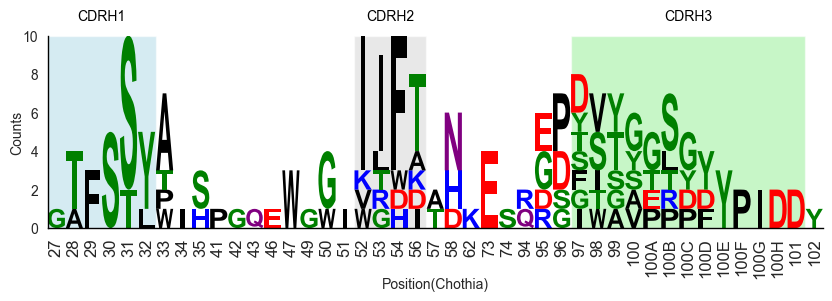

In [387]:
data = amino_acid_proportions
data1 = amino_acid_contact_proportions

# Determine the maximum length among all positions
max_length = max(len(amino_acids) for amino_acids in data.values())

# Function to create a BioPython SeqRecord for a given position
def create_seq_record(amino_acids_data):
    amino_acids = list(amino_acids_data.keys())
    amino_acids_count = [amino_acids_data.get(aa, 0) for aa in amino_acids]

    seq = Seq(''.join(amino_acids))
    record = SeqRecord(seq)
    record.letter_annotations = {'height': amino_acids_count}
    return record

# Create the sequence records for each position
sequence_records = [create_seq_record(location) for location in data.values()]
def seqlogo_fromdict(dict):
    # Prepare data for logomaker
    df = pd.DataFrame.from_dict(dict)
    df = df.transpose()
    df = df.fillna(0)
    df = df.astype(int)
    chothia_ind = df.index
    df.reset_index(drop=True, inplace=True)

    # Create the sequence logo using logomaker
    logo = logomaker.Logo(df, center_values=False, color_scheme='chemistry')


    # Customize the logo
    logo.ax.grid(visible=False)
    logo.style_xticks()
    logo.style_spines(visible=False)
    logo.style_spines(spines=['left','bottom'], visible=True)
    logo.ax.set_xticks(range(len(chothia_ind)))
    logo.ax.set_xticklabels(chothia_ind, rotation=90, fontsize=12)
    logo.highlight_position_range(0, 5, alpha = 0.5, color = 'lightblue')
    logo.highlight_position_range(17, 20, alpha = 0.5, color = 'lightgray')
    logo.highlight_position_range(29, 41, alpha = 0.5, color = 'lightgreen')
    logo.ax.text(2.5, 11, "CDRH1", fontsize=10, color='black', ha='center', va='center')
    logo.ax.text(18.5, 11, "CDRH2", fontsize=10, color='black', ha='center', va='center')
    logo.ax.text(35, 11, "CDRH3", fontsize=10, color='black', ha='center', va='center')
    logo.ax.set_xlabel("Position(Chothia)", fontsize=10, va='center')
    logo.ax.set_ylabel("Counts", fontsize=10, va='center')
    plt.savefig("../Data/Figures/SeqLogo/vh_match_contact_data.png", dpi=500,  bbox_inches='tight')
    # Create the sequence logo chart
def seqlogo_fromdict_cdr(dict):
    # Prepare data for logomaker
    df = pd.DataFrame.from_dict(dict)
    df = df.transpose()
    df = df.fillna(0)
    df = df.astype(int)
    chothia_ind = df.index
    df.reset_index(drop=True, inplace=True)
    # Create the sequence logo using logomaker
    logo = logomaker.Logo(df, center_values=False, color_scheme='chemistry')

    # Customize the logo
    logo.ax.grid(visible=False)
    logo.style_xticks()
    logo.style_spines(visible=False)
    logo.style_spines(spines=['left','bottom'], visible=True)
    logo.ax.set_xticks(range(len(chothia_ind)))
    logo.ax.set_xticklabels(chothia_ind, rotation=90, fontsize=12)
    logo.highlight_position_range(0, 6, alpha = 0.5, color = 'lightblue')
    logo.highlight_position_range(7, 12, alpha = 0.5, color = 'lightgray')
    logo.highlight_position_range(13, 39, alpha = 0.5, color = 'lightgreen')
    logo.ax.text(3, 15, "CDRH1", fontsize=10, color='black', ha='center', va='center')
    logo.ax.text(9.5, 15, "CDRH2", fontsize=10, color='black', ha='center', va='center')
    logo.ax.text(21, 15, "CDRH3", fontsize=10, color='black', ha='center', va='center')
    logo.ax.set_xlabel("Position(Chothia)", fontsize=10, va='center')
    logo.ax.set_ylabel("Counts", fontsize=10, va='center')
    plt.savefig("../Data/Figures/SeqLogo/vh_match_cdr_data.png", dpi=500,  bbox_inches='tight')
    # Create the sequence logo chart
    plt.tight_layout()
seqlogo_fromdict(data1)